## Make Storms, Make Erosion

Contributors: Mariel Nelson, Sam Anderson, Grace Guryan, Safiya Alpheus, Angel Monsalve, Muriel Brückner

**Introduction:**<br>
Landscape evolution models such as the stream power incision model (e.g. Lague, 2013) typically assume constant hydrologic conditions when modeling river evolution. Two Landlab components, the *Overland Flow* and *Detachment Limited Erosion* components,  have recently been developed to model river incision in response to specific hydrologic conditions produced by storm events. This notebook couples these two components with a component called *SpatialPrecipitationDistribution* that models storm events to explore how different storm patterns result in different erosion patterns in a catchment mainly dominated by overland flow, e.g. impermeable rock or saturated soils. This notebook builds on the previous Overland Flow/Detachment Limited Erosion tutorial by exploring the incision produced by storms with different intensity and duration.


These exercises were modified from the following tutorial notebooks in the landlab directory:
* https://github.com/landlab/csdms_model_clinic_may_2017/blob/master/OverlandFlowErosionExample/OverlandFlow_Erosion.ipynb
* https://hub.mybinder.turing.ac.uk/user/landlab-landlab-i1ydeh37/notebooks/notebooks/tutorials/overland_flow/coupled_rainfall_runoff.ipynb
* https://github.com/landlab/landlab/blob/8967ea72ab49e48143b3d9bbeb9a27c8fc5d95f9/notebooks/tutorials/overland_flow/coupled_rainfall_runoff.ipynb

Coding objectives:
1. Generating different types of precipitation events
1. Loading a steady state DEM
1. Couple multiple components in landlab (e.g., SpatialPrecipitationDistribution, OverlandFlow, DetachmentLimitedErosion)
1. Plotting results with MatPlotLib


Science objectives:
1. Understand how different storms (varying in intensity, duration, frequency?) influence how river channels erode

Future implications:
1. Understanding the differences between predictions of incision through either drainage area estimation or storm flux calculations using the shallow water equations



**Components used:**

SpatialPrecipitationDistribution:<br>
The *SpatialPrecipitationDistribution* generates spatially resolved precipitation events. It generates a sequence of spatially resolved storms over a grid using the stochastic methods of Singer & Michaelides (2017).

https://csdms.colorado.edu/wiki/Model:SpatialPrecipitationDistribution

OverlandFlow:<br>
The *OverlandFlow* component models flow using the shallow water equations over a landscape in response to a flood or precipitation event using the de Almeida algorithm. 

https://csdms.colorado.edu/wiki/Model:OverlandFlow

DetachmentLtdErosion:<br>
The *DetachmentLimitedErosion* component calculates the erosion rate based on stream power theory. It is designed to work specifically with the overland flow component. 

https://csdms.colorado.edu/wiki/Model:DetachmentLtdErosion

SinkFiller:<br>
Landlab model component that uses the Barnes et al (2014) algorithms to replace pits in a topography with flats, or optionally with very shallow gradient surfaces to allow continued draining. We use this to prepare the raster model grid for hydrologic analysis.
link: https://csdms.colorado.edu/wiki/Model:SinkFiller



## PART 1: Make Storms
Import important packages

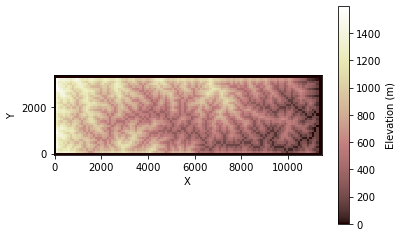

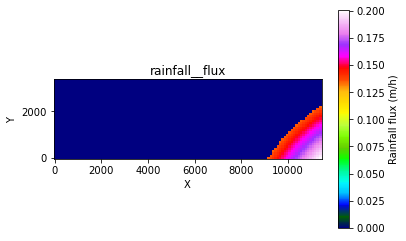

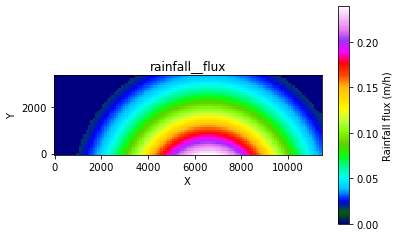

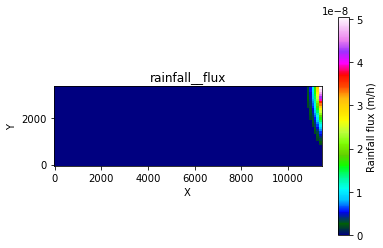

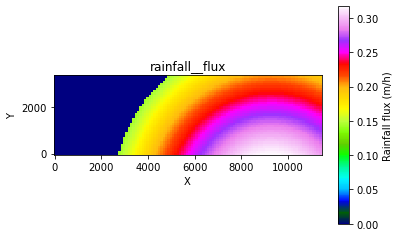

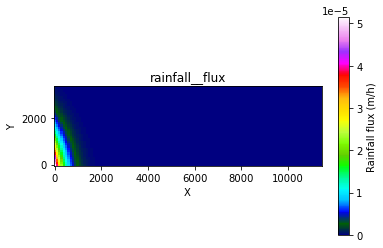

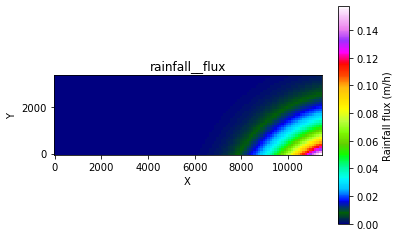

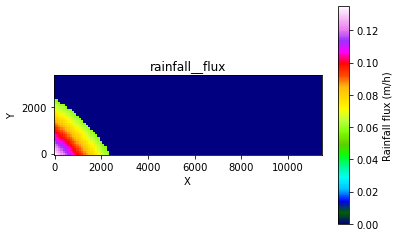

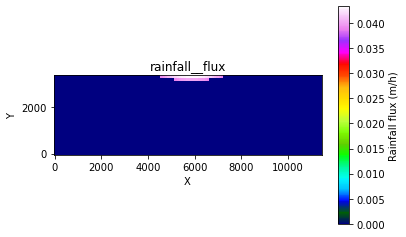

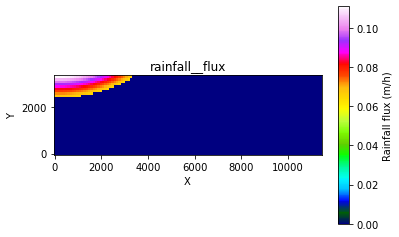

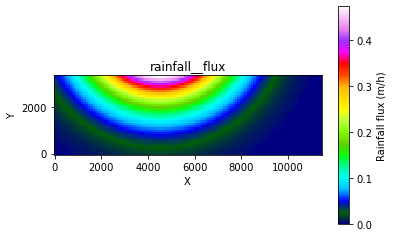

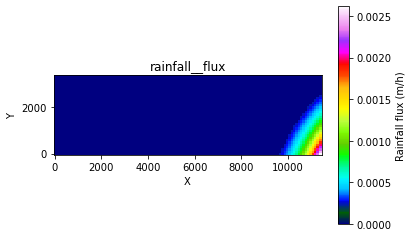

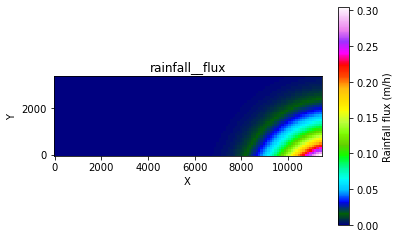

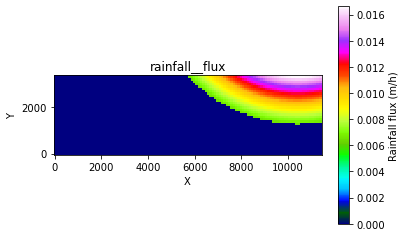

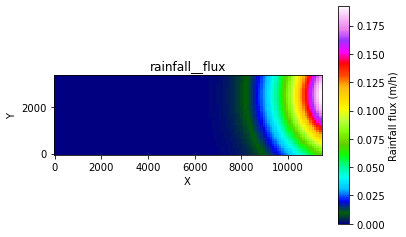

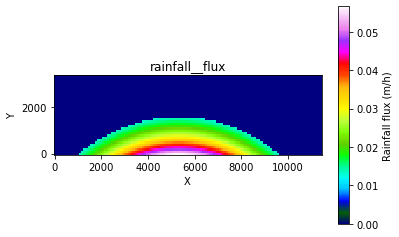

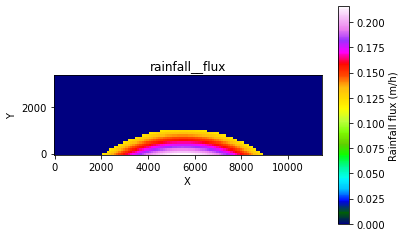

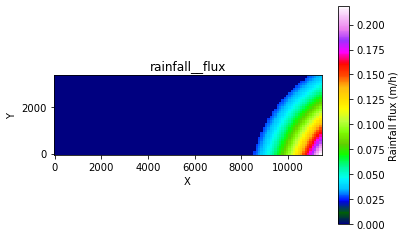

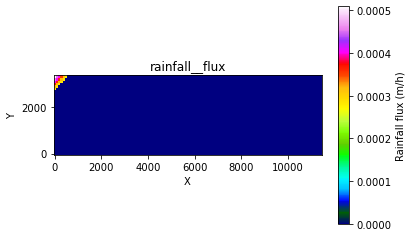

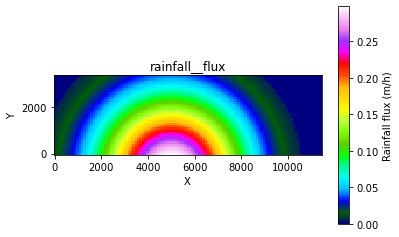

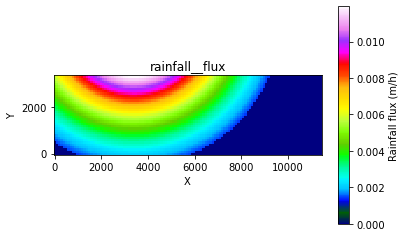

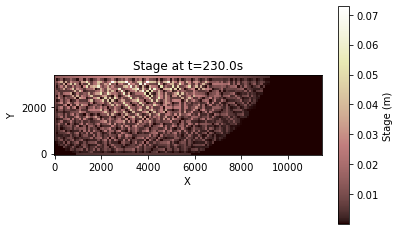

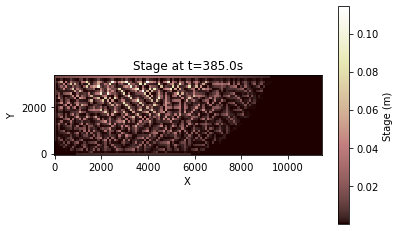

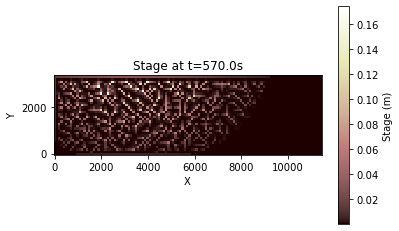

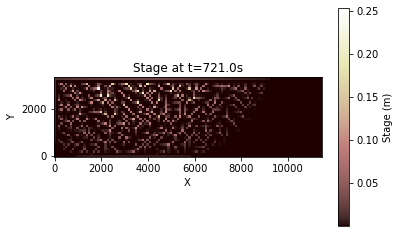

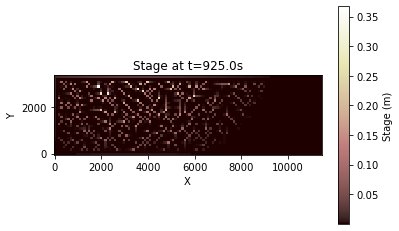

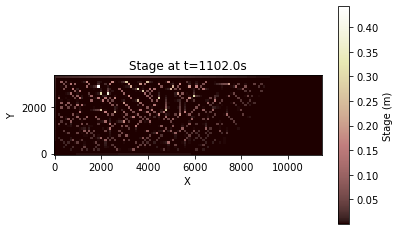

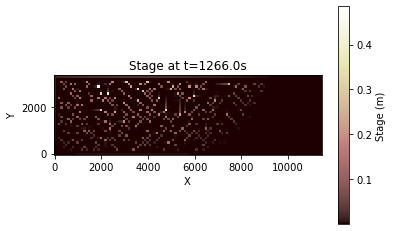

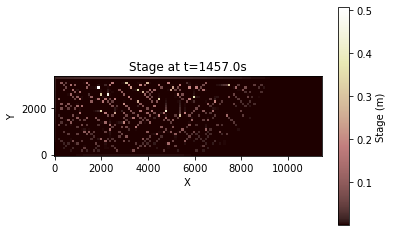

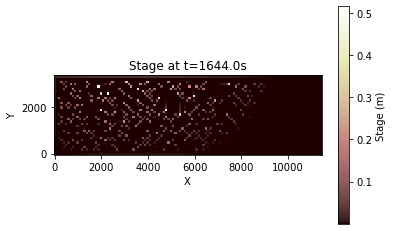

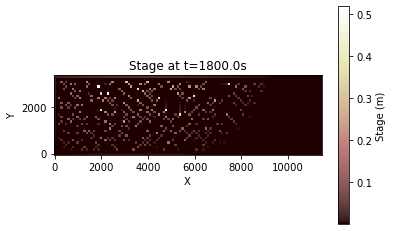

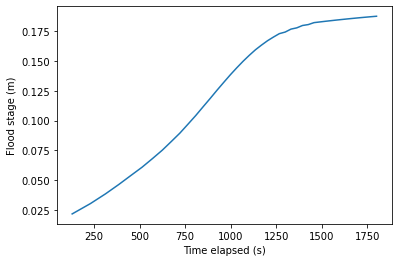

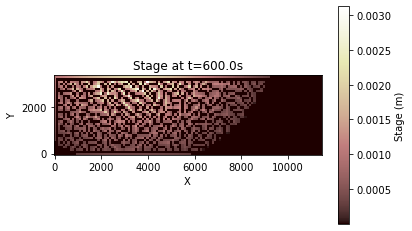

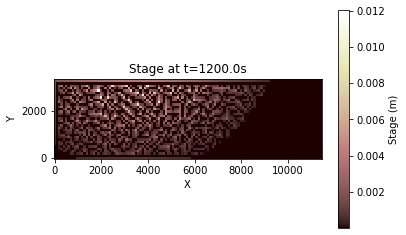

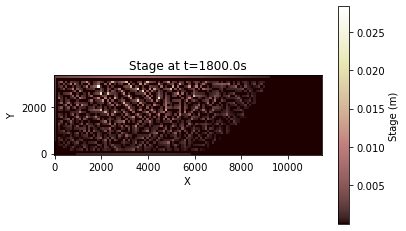

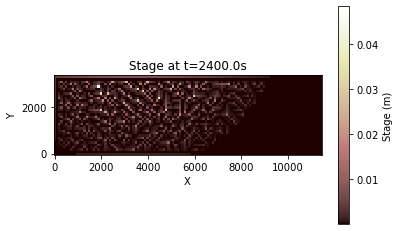

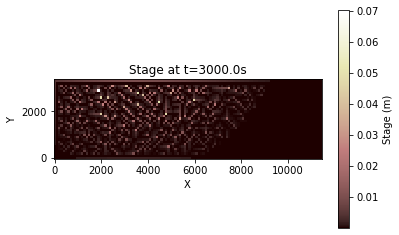

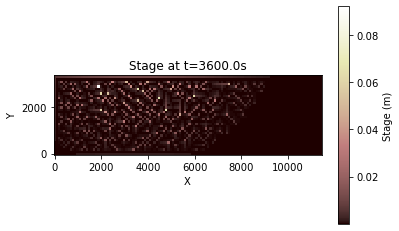

Text(0, 0.5, 'Flood stage (m)')

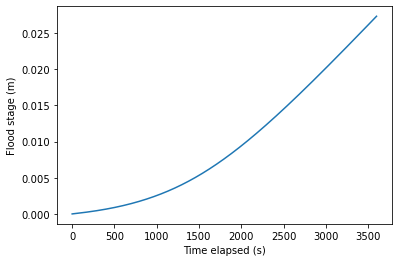

In [2]:
from landlab.components import SpatialPrecipitationDistribution, OverlandFlow
import numpy as np
import matplotlib.pyplot as plt
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii, write_esri_ascii
import os 
from landlab import imshow_grid_at_node


#initial topo and show it
(mg, z) = read_esri_ascii('steady_state.asc', 
                          name="topographic__elevation")

plt.figure()
imshow_grid(mg, z, colorbar_label='Elevation (m)')
plt.show()

rain = SpatialPrecipitationDistribution(mg)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every time

# get the storm simulator to provide a storm
# There's only one storm generated here in the time series, so easy enough to do.
# first, check the directory we need for saving exists, and make it if not:
if not os.path.exists('./rainfall'):
    os.makedirs('./rainfall')
for (storm_t, interstorm_t) in rain.yield_storms(style='monsoonal'):  # storm lengths in hrs
    mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    mg.at_node['rainfall__flux'] *= 10.  # to make the storm heavier and more interesting!
    plt.figure()
    # plot up this storm
    imshow_grid_at_node(
        mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (m/h)'
    )
    plt.show()
    write_esri_ascii('./rainfall/rainfall.asc', mg, 'rainfall__flux', clobber=True)

for filename in os.listdir('./rainfall'):  # for each file in the folder
    if filename.endswith(".asc"):  # ...that ends with .asc...
        # remove any rainfall field that already exists on the grid:
        try:
            _ = mg.at_node.pop('rainfall__flux')
        except KeyError:
            pass
        _, q_rain = read_esri_ascii(
            './rainfall/'+filename, grid=mg, name='rainfall__flux')
    else:
        continue
    mg.add_zeros("surface_water__depth", at="node")   
    mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
    mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * storm_t
    of = OverlandFlow(mg, steep_slopes=True)
    

    # storm_t here is the duration of the rainfall, from the rainfall component
    # We're going to assume the rainfall arrives effectively instantaneously, but
    # adding discharge during the run is completely viable

    node_of_max_q = 2126  # established by examining the output of a previous run
    outlet_depth = []
    outlet_times = []
    post_storm_elapsed_time = 0.
    last_storm_loop_tracker = 0.
    while post_storm_elapsed_time < 0.5 * 3600.:  # plot 30 mins-worth of runoff
        dt = of.calc_time_step()
        of.run_one_step(dt=dt)
        post_storm_elapsed_time += dt
        storm_loop_tracker = post_storm_elapsed_time % 180.  # show every 3 min
        # NB: Do NOT allow this plotting if there are multiple files in the folder
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)')
            plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(post_storm_elapsed_time)
        
plt.figure()
plt.plot(outlet_times, outlet_depth, '-')
plt.xlabel('Time elapsed (s)')
plt.ylabel('Flood stage (m)')


#DISTRIBUTED STORMS ARE BELOW!!!!


for filename in os.listdir('./rainfall'):  # for each file in the folder
    if filename.endswith(".asc"):  # ...that ends with .asc...
        # remove any rainfall field that already exists on the grid:
        try:
            _ = mg.at_node.pop('rainfall__flux')
        except KeyError:
            pass
        _, q_rain = read_esri_ascii(
            './rainfall/'+filename, grid=mg, name='rainfall__flux')
    else:
        continue
      
    mg.at_node['surface_water__depth'].fill(1.e-12)

    of = OverlandFlow(mg, steep_slopes=True)
    node_of_max_q = 2126
    total_mins_to_plot = 60.  # plot 60 mins-worth of runoff
    plot_interval_mins = 10.  # show every 10 min
    min_tstep_val = 1.  # necessary to get the model going cleanly
    outlet_depth = []
    outlet_times = []
    storm_elapsed_time = 0.
    total_elapsed_time = 0.
    last_storm_loop_tracker = 0.
    while total_elapsed_time < total_mins_to_plot * 60.:
        dt = of.calc_time_step()
        remaining_total_time = total_mins_to_plot * 60. - total_elapsed_time
        if storm_elapsed_time < storm_t * 3600.:
            remaining_storm_time = storm_t * 3600. - storm_elapsed_time
            dt = min((dt, remaining_total_time, remaining_storm_time, min_tstep_val))
        else:
            dt = min((dt, remaining_total_time, min_tstep_val))
        of.run_one_step(dt=dt)
        total_elapsed_time += dt
        storm_elapsed_time += dt
        storm_loop_tracker = total_elapsed_time % (plot_interval_mins * 60.)
        # NB: Do NOT allow this plotting if there are multiple files in the folder
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)')
            plt.title('Stage at t=' + str(total_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(total_elapsed_time)
        if storm_elapsed_time < storm_t * 3600.:
            mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * dt / 3600.
            
plt.figure()
plt.plot(outlet_times, outlet_depth, '-')
plt.xlabel('Time elapsed (s)')
plt.ylabel('Flood stage (m)')

## PART 2: Make Erosion

Import important packages

In [4]:
from landlab.components import OverlandFlow, DetachmentLtdErosion, SinkFiller
from landlab.io import read_esri_ascii
from landlab import imshow_grid
import numpy as np
import copy
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Import DEM file, make raster grid and assign elevations to the grid.

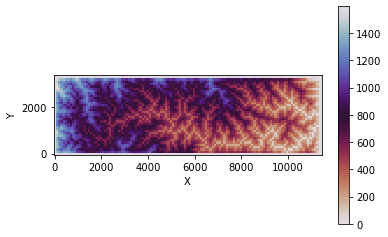

array([1493])

In [5]:
max_dt = 10  
tPlot = 43200 # seconds

storm_flag = 'Base' # 'Base' or'HigherIntensity' or 'LongerDuration'

watershed_dem = 'steady_state.asc'
link_to_sample = 1492
node_to_sample = 1493

(rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
imshow_grid(rmg, 'topographic__elevation', vmin=0, cmap='twilight_r')  # plots the DEM
plt.show()

z = np.where(z == 0, -9999.0, z)

#rmg.set_watershed_boundary_condition_outlet_id((1493), z, -9999.)

#Use sink filler to fill in holes
# DONT USE D8!
sf = SinkFiller(rmg, routing='D4', apply_slope=True, fill_slope=1.e-5)
sf.fill_pits()
z_initial = copy.deepcopy(z)

rmg.set_watershed_boundary_condition(z, -9999, return_outlet_id = True)

Check to make sure output node is assigned correctly. 
Boundary cells are blue, outlet node is white, interior nodes are black.

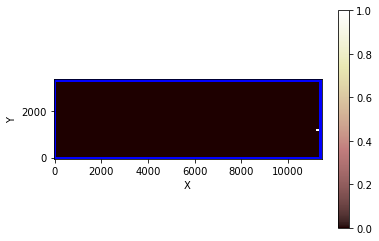

In [6]:
imshow_grid(rmg, rmg.status_at_node, color_for_closed='blue')

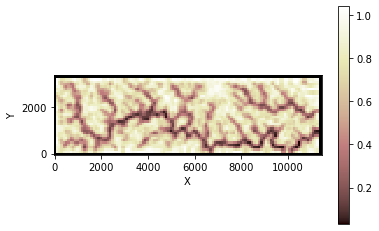

In [7]:
rmg.add_zeros('surface_water__depth', at = 'node')   
rmg.at_node['surface_water__depth'].fill(1.e-12)
rmg.add_zeros('surface_water__discharge', at='link')    # All cells are dry at the beginning of the simulation - no discharge

# I don't know if these variables are used
rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
rmg['node']['water_surface__slope'] = np.zeros(rmg.number_of_nodes)

# Also, DetachmentLtdErosion requires the calculation of the 'topographic__slope'
rmg.at_node['topographic__slope'] = rmg.calc_slope_at_node(elevs='topographic__elevation')
imshow_grid(rmg, 'topographic__slope');
plt.show()

Instantiate OverlandFlow and DetachmentLimitedErosion

In [8]:
# Initialization
of = OverlandFlow(rmg, mannings_n=0.03, steep_slopes=True, alpha = 0.3)   # instantiate OverlandFlow object
dle = DetachmentLtdErosion(rmg, K_sp = 1.259162261 * (10**-3)) #instantiate DetachmentLtdErosion object

* Now we set the boundary conditions, instantiate the components, and set the appropriate storm parameters.
  * All `NODATA` nodes in the DEM are closed boundaries and the outlet is set to an open boundary. This is all done in `rmg.set_watershed_boundary_condition(z)`.
 

Set the precipitation conditions for the model run, if you aren't using the PrecipitationDistribution component

In [16]:
if storm_flag == 'Base':
    starting_precip_mmhr = 20.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 20000.
elif storm_flag == 'HigherIntensity':
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 200.
elif storm_flag == 'LongerDuration':
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 14400.

* Before we go further, let's pause to look at the landscape that we will be routing flow over.

* Initialize a few more parameters, and getting ready to run the time loop and save data for plotting.
  * These two components take time steps in *seconds*

In [17]:
uplift_rate = 3.170979 * (10**-10) # m/s

elapsed_time = 1.0
model_run_time = 43200.0 # s

discharge_at_outlet = []
hydrograph_time = []
incision_at_outlet = []

* Let's run the time loop, that is, generate overland flow and erode!

In [18]:
while elapsed_time < model_run_time:
    
    of.dt = min(max_dt,of.calc_time_step())
                
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  starting_precip_ms  
    else:
        of.rainfall_intensity = 0.0

    of.overland_flow()
    of.dt = min(max_dt,of.calc_time_step())
   
    node_slope = (of._water_surface_slope[rmg.links_at_node] * rmg.active_link_dirs_at_node)
    incision_Q = np.abs(of._q * rmg.dx)[rmg.links_at_node]
    rmg['node']['surface_water__discharge'] = (incision_Q[np.arange(len(node_slope)), np.argmax(node_slope, axis=1)])
   
    node_slope = node_slope.max(axis=1)
    rmg['node']['water_surface__slope'] = node_slope

    dle.run_one_step(of.dt)

    rmg['node']['topographic__elevation'] += uplift_rate * of.dt

    hydrograph_time.append(elapsed_time)
    discharge_at_outlet.append(np.abs(of._q[link_to_sample]) * rmg.dx)
    incision_at_outlet.append(dle._I[node_to_sample])
    #print(incision_at_outlet)
    tPlot = tPlot-of.dt
    if tPlot <= 0:
        print('Elapsed time :',elapsed_time,' s. Current dt =',of.dt,' s')
        #imshow_grid(rmg, 'surface_water__discharge', cmap='Blues');
        #plt.show()
       
        #tPlot = 5000

    elapsed_time += of.dt

Elapsed time : 1.0  s. Current dt = 10  s
Elapsed time : 11.0  s. Current dt = 10  s
Elapsed time : 21.0  s. Current dt = 10  s
Elapsed time : 31.0  s. Current dt = 10  s
Elapsed time : 41.0  s. Current dt = 10  s
Elapsed time : 51.0  s. Current dt = 10  s
Elapsed time : 61.0  s. Current dt = 10  s
Elapsed time : 71.0  s. Current dt = 10  s
Elapsed time : 81.0  s. Current dt = 10  s
Elapsed time : 91.0  s. Current dt = 10  s
Elapsed time : 101.0  s. Current dt = 10  s
Elapsed time : 111.0  s. Current dt = 10  s
Elapsed time : 121.0  s. Current dt = 10  s
Elapsed time : 131.0  s. Current dt = 10  s
Elapsed time : 141.0  s. Current dt = 10  s
Elapsed time : 151.0  s. Current dt = 10  s
Elapsed time : 161.0  s. Current dt = 10  s
Elapsed time : 171.0  s. Current dt = 10  s
Elapsed time : 181.0  s. Current dt = 10  s
Elapsed time : 191.0  s. Current dt = 10  s
Elapsed time : 201.0  s. Current dt = 10  s
Elapsed time : 211.0  s. Current dt = 10  s
Elapsed time : 221.0  s. Current dt = 10  s

* Let's look at the data.

Text(0.5, 1.0, 'Hydrograph at Watershed Outlet')

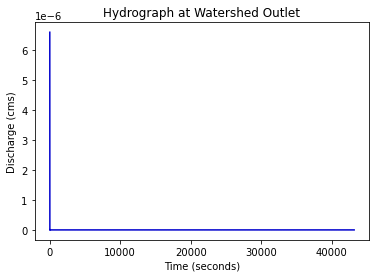

In [12]:
plt.figure(1)
plt.plot(hydrograph_time, discharge_at_outlet, color='mediumblue')
plt.ylabel('Discharge (cms)')
plt.xlabel('Time (seconds)')
plt.title('Hydrograph at Watershed Outlet')

# files = plt.savefig('HydrographAtBasinOutlet.png')

Text(0.5, 1.0, 'Incision at Watershed Outlet')

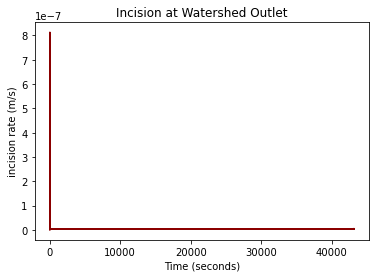

In [13]:
plt.figure(2)
plt.plot(hydrograph_time, incision_at_outlet, color='darkred')
plt.ylabel('incision rate (m/s)')
plt.xlabel('Time (seconds)')
plt.title('Incision at Watershed Outlet')

# files = plt.savefig('HydrographAtBasinOutlet.png')

* Let's look at the change in the topography, first including uplift.
  * The colorbar is limited to beter show patterns.
  * Because we didn't take out uplift, there are some locations in which elevation has actually increased.

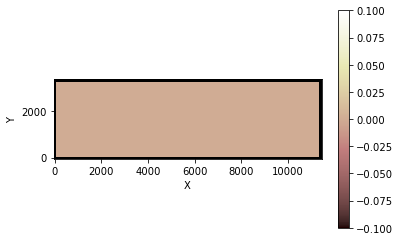

In [14]:
z_diff = z - z_initial # the difference in elevation from start to finish
imshow_grid(rmg, z_diff)#, limits=(-0.00004, np.max(z_diff)))  

* We can take out uplift in order to just look at incision rates and patterns.
  * We again limit the color bar to highlight patterns

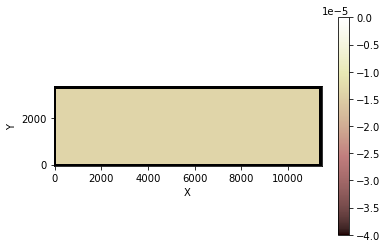

In [15]:
### this is just fluvial incision, which will be negative
z_diff = z - z_initial - uplift_rate * model_run_time 
imshow_grid(rmg, z_diff, limits=(-0.00004, 0.0))

## References:
all of the notebooks